In [1]:
import os
import copy
from functools import reduce
import random

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import dask
import gpflow
import glob
import xesmf as xe

from matplotlib.patches import Rectangle
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from esem import gp_model
from sklearn.metrics import root_mean_squared_error
from esem.utils import get_random_params

from SALib.sample import fast_sampler
from SALib.analyze import fast

2024-02-24 13:00:50.646298: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-24 13:00:50.701278: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                     # The number of cores you want
    memory='25GB',                               # Amount of memory
    processes=1,                                 # How many processes
    queue='casper',                              # The type of queue to utilize
    local_directory='/glade/work/afoster',       # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',   # Specify resources
    project='P93300041',                         # Input your project ID here
    walltime='04:00:00',                         # Amount of wall time
    interface='ext',                             # Interface to use
)

/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38837 instead
  warnings.warn(


In [3]:
cluster.scale(2)

/glade/work/afoster/conda-envs/ml_analysis/lib/python3.11/site-packages/dask_jobqueue/pbs.py:82: FutureWarning: project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check config files). If you did not set account yet, project will be respected for now, but it will be removed in a future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


In [4]:
client = Client(cluster)

In [5]:
def split_dataset(var, params, n_test):

    # target variable (excluding default [0])
    Y = var[1:].values

    # test and training parameters
    X_test, X_train = params[:n_test], params[n_test:]

    # test and training output
    y_test, y_train = Y[:n_test], Y[n_test:]

    return X_test, X_train, y_test, y_train

In [6]:
def train_emulator(num_params, X_train, y_train):

    # create kernel
    kernel_linear = gpflow.kernels.Linear(active_dims=range(num_params),
                                          variance=1)
    kernel_matern32 = gpflow.kernels.Matern32(active_dims=range(num_params),
                                              variance=1,
                                              lengthscales=np.tile(1, num_params))
    kernel = kernel_linear + kernel_matern32

    # define emulator model and train
    emulator = gp_model(np.array(X_train), np.array(y_train), kernel=kernel)
    emulator.train()

    return emulator

In [7]:
def test_emulator(emulator, params, test, var):

    # predict test points with emulator
    pred, pred_var = emulator.predict(params)
    df = {f'{var}_test': test,
          f'{var}_pred': pred,
          f'{var}_var': pred_var}

    return pd.DataFrame(df)

In [8]:
def fourier_sensitivity(emulator):

    # fourier amplitude sensitivity test w/emulator
    problem = {
        'names': ppe_params.columns,
        'num_vars': num_params,
        'bounds': [[0, 1]],
    }

    sample = fast_sampler.sample(problem, 1000, M=4, seed=None)
    Y, _ = emulator.predict(sample)
    FAST = fast.analyze(problem, Y, M=4, num_resamples=100, conf_level=0.95,
                        print_to_console=False, seed=None)
    sens = pd.DataFrame.from_dict(FAST)
    sens.index = sens.names
    df_sens = sens.sort_values(by=['S1'], ascending=False)

    return df_sens

In [9]:
def oaat_sensitivity(ppe_params, emulator):
    
    num_params = len(ppe_params.columns)

    # hold all parameters at median value
    n = 50
    unif = pd.concat([pd.DataFrame(np.tile(0.5, n))]*num_params, axis=1)
    unif.columns = ppe_params.columns
    s = np.linspace(0, 1, n)
    param = np.array([])
    oaats = np.array([])
    vars = np.array([])
    samps = np.array([])
    sample = unif
    for i, p in enumerate(ppe_params.columns):
        sample[p] = s
        oaat, v = emulator.predict(sample.values)
        sample[p] = np.tile(0.5, n)  # set column back to median
        oaats = np.append(oaats, oaat)
        vars = np.append(vars, v)
        param = np.append(param, np.repeat(p, n))
        samps = np.append(samps, s)
    df = {'sample': samps,
      'predict': oaats,
      'variance': vars,
      'parameter': param}
    dataf = pd.DataFrame(df)
    return dataf

In [10]:
def train_and_test_var(ds, ppe_params, n_test, var, average_dim=None):

    # take average if required
    if average_dim is not None:
        average_var = ds[var].mean(dim=average_dim)
    else:
        average_var = ds[var]

    # split into testing and training
    params_test, params_train, var_test, var_train = split_dataset(average_var,
                                                                   ppe_params,
                                                                   n_test)

    # train emulator
    em = train_emulator(num_params, params_train, var_train)

    # create data frames for output
    var_preds = test_emulator(em, params_test, var_test, var)
    var_sens = fourier_sensitivity(em)
    var_oaat = oaat_sensitivity(ppe_params, em)

    return var_preds, var_sens, var_oaat, em

In [11]:
def train_and_test_allvars(ds, ppe_params, n_test, vars, outdir, file_tag,
                           average_dim=None):
    all_preds = []
    all_sens = []
    all_oaat = []
    all_em = dict()
    for variable in vars:
        var_preds, var_sens, var_oaat, em = train_and_test_var(ds, ppe_params,
                                                               n_test, variable,
                                                               average_dim)
        var_preds['variable'] = variable
        var_preds.columns = ['test', 'pred', 'variance', 'variable']
        all_preds.append(var_preds)

        var_sens['variable'] = variable
        all_sens.append(var_sens)
        
        var_oaat['variable'] = variable
        all_oaat.append(var_oaat)
        
        if variable in all_em:
            print('error')
        else:
            all_em[variable] = em

    return pd.concat(all_preds), pd.concat(all_sens), pd.concat(all_oaat), all_em

In [21]:
def plot_emulator_validation(var_preds, var, units, pft):

    sqrt = np.sqrt(var_preds[f"{var}_var"])
    rms = root_mean_squared_error(var_preds[f"{var}_test"], var_preds[f"{var}_pred"])

    plt.figure()
    plt.scatter(var_preds[f"{var}_test"], var_preds[f"{var}_pred"])
    plt.plot([min(var_preds[f"{var}_test"]), max(var_preds[f"{var}_test"])],
             [min(var_preds[f"{var}_test"]), max(var_preds[f"{var}_test"])],
             c='k', linestyle='--', label='1:1 line')
    plt.errorbar(var_preds[f"{var}_test"], var_preds[f"{var}_pred"],
                 yerr=2*sqrt, fmt="o")
    plt.text(min(var_preds[f"{var}_test"]), max(var_preds[f"{var}_test"]), 
             'RMSE = {}'.format(np.round(rms, 3)))
    plt.xlabel(f'FATES {pft} mean annual mean {var} ({units})')
    plt.ylabel(f'Emulated {pft} mean annual mean {var} ({units})')
    plt.legend(loc='lower right')

In [13]:
def plot_fourier_sensivity(sens_df, title):

    plt.figure(num=None, figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 12})

    ax = plt.subplot(1, 1, 1)
    ax.bar(sens_df.names, sens_df['ST'], color='lightgrey', label='interactions')
    ax.bar(sens_df.names, sens_df['S1'], color='darkolivegreen', label='main effects')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.legend(loc='upper right')
    plt.ylabel('Proportion of total emulated variance (total=1)')
    plt.title(title)
    plt.tight_layout()

In [14]:
def plot_oaat_sens(ppe_params, emulator):

    num_params = len(ppe_params.columns)

    # hold all parameters at median value
    n = 21
    unif = pd.concat([pd.DataFrame(np.tile(0.5, n))]*num_params, axis=1)
    unif.columns = ppe_params.columns
    s = np.linspace(0, 1, n)

    sample = unif
    plt.figure(figsize=[18, 16])
    for i, p in enumerate(ppe_params.columns):
        sample[p] = s
        oaat, v = emulator.predict(sample.values)
        sample[p] = np.tile(0.5, n)  # set column back to median

        ax = plt.subplot(7, 5, i + 1)
        ax.fill_between(s, oaat - 3.0*v**0.5, oaat + 3.0*v**0.5, color='peru',
                        alpha=0.4)  # shade three standard deviations
        ax.plot(s, oaat, c='k')
        ax.set_xlabel(p)
    plt.tight_layout()

In [22]:
def plot_sampled_hist(pred_sampled, obs_mean, obs_var, varname, units, out_dir, ens, pft):

    plt.figure(figsize=(7, 5))
    ax = plt.subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.xticks(fontsize=11)

    my_hist, bin_edges = np.histogram(pred_sampled, bins=40)
    maxv = my_hist.max()
    plt.xlabel(f"Emulated {pft} Annual {varname} ({units})", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.hist(pred_sampled, fc="darkgray", bins=40)
    ax.add_patch(Rectangle((obs_mean - np.sqrt(obs_var), 0), 2*np.sqrt(obs_var), maxv,
                           facecolor='red', alpha=0.4))
    plt.savefig(os.path.join(out_dir, f'{varname}_{pft}_sample_{ens}.png'))

In [16]:
def implausibility_metric(pred, obs, pred_var, obs_var):

    top = np.abs(pred - obs)
    bottom = np.sqrt(pred_var + obs_var)

    imp = top/bottom

    return imp

In [17]:
def plot_sampled_implausibility(imp, title, plausibility_tolerance):

    plt.figure(figsize=(7, 5))
    ax = plt.subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.xticks(fontsize=11)    
    plt.xlabel(f"Implausibility Score", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    
    my_hist, bin_edges = np.histogram(imp.flatten(), bins=40)

    # Define color thresholds
    lower_bound = plausibility_tolerance
    lower_tail_color = "#69B3A2"
    hist_center_color = "darkgray"
    
    # Init the list containing the color of each bin.
    colors = []
    for bin_edge in bin_edges:
    
        # Light blue: Assign a color to the bin if its edge is less than 'lower_bound'
        if bin_edge < lower_bound:
            colors.append(lower_tail_color)
        
        # Assign a color to the bin 
        else:
            colors.append(hist_center_color)

    plt.bar(
        bin_edges[:-1], 
        my_hist, 
        width=np.diff(bin_edges), 
        color=colors, 
        edgecolor='none'
    )

In [23]:
def emulator_sample(emulator, sample, obs_values, plausibility_tolerance,
                    varname, units, sim_var, pft, out_dir, ens):
    
    pred_sampled, pred_sampled_var = emulator.predict(sample)
    plot_sampled_hist(pred_sampled, obs_values.mean(), obs_values.var(),
                      varname, units, out_dir, ens, pft)
    
    implaus = implausibility_metric(pred_sampled, obs_values.mean(),
                                    pred_sampled_var, obs_values.var())
    plausible_values = np.where(implaus < plausibility_tolerance)[0]
    
    plot_sampled_implausibility(implaus, f"Implausibility for {sim_var} and {pft}",
                                plausibility_tolerance)
    plt.savefig(os.path.join(out_dir, f'{varname}_{pft}_plausibility_{ens}.png'))

    sample_df = pd.DataFrame(sample)
    sample_df.columns = ppe_params.columns
    sample_df[f'{sim_var}_good'] = False
    if len(plausible_values) > 0:
        sample_df.loc[plausible_values, f'{sim_var}_good'] = True

    return sample_df

In [34]:
ens = 500
ds = xr.open_dataset(f'../LH/LH{ens}_sparsegrid_output.nc')

In [35]:
if ens == 500:
    lhckey = '/glade/u/home/afoster/FATES_Calibration/FATES_SP/LH/lh_key.csv'
    df = pd.read_csv(lhckey)
    ppe_params = df.drop(columns=['ensemble'])
elif ens == 300:
    lhckey = '/glade/work/afoster/FATES_calibration/FATES_SP_LH/lh_key_300.csv'
    df = pd.read_csv(lhckey)
    ppe_params = df
num_params = len(ppe_params.columns)

In [36]:
n_test = 50
plausibility_tolerance = 3
n_samp = 5000

In [37]:
random.seed(12345)
sample = get_random_params(num_params, n_samp)
sample_update = sample
for i in range(len(sample_update)):
    sample_update[i][1] = 1.0
    sample_update[i][6] = 1.0

In [38]:
grid_pfts = pd.read_csv('../surfdata/grid_pfts_dominant.csv')
fates_pfts = grid_pfts.pft.values

In [39]:
obs = pd.read_csv('../observations/ILAMB_sparsegrid_data.csv')
out_dir = f'../LH/LH_output_byPFT{ens}'

In [40]:
vars = ['GPP', 'EFLX_LH_TOT', 'FSH']
obs_vars = ['gpp', 'et', 'sh']
varnames = ['GPP',
            'ET',
            'SH']
units = ['kgC m$^{-2}$ yr$^{-1}$',
        'kgH$_2$O m$^{-2}$ yr$^{-1}$',
        'W m$^{-2}$']

evaluating at 13 grids for broadleaf evergreen tropical tree
evaluating at 20 grids for needleleaf evergreen extratrop tree
evaluating at 4 grids for needleleaf colddecid extratrop tree
number of gridcells too few (0) for broadleaf evergreen extratrop tree
number of gridcells too few (0) for broadleaf hydrodecid tropical tree
number of gridcells too few (0) for broadleaf colddecid extratrop tree
number of gridcells too few (0) for broadleaf evergreen extratrop shrub
number of gridcells too few (1) for broadleaf hydrodecid extratrop shrub
number of gridcells too few (1) for broadleaf colddecid extratrop shrub
evaluating at 8 grids for arctic c3 grass


/glade/derecho/scratch/afoster/tmp/ipykernel_23341/2475750970.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7, 5))


evaluating at 4 grids for cool c3 grass
evaluating at 12 grids for c4 grass
number of gridcells too few (3) for c3 crop
number of gridcells too few (0) for c3 irrigated


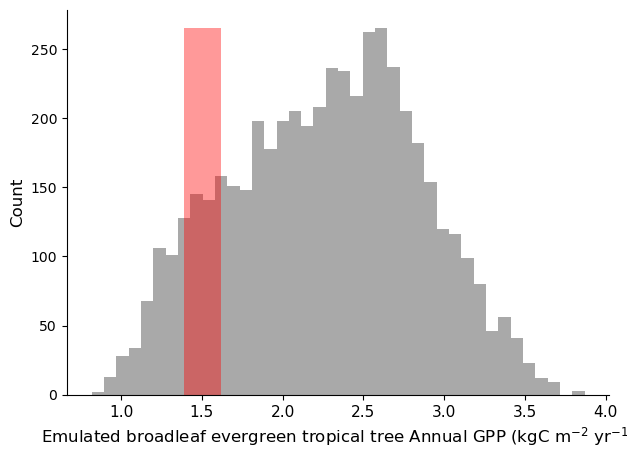

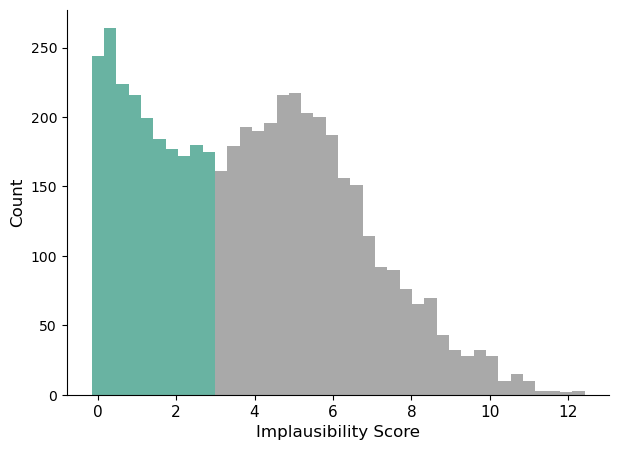

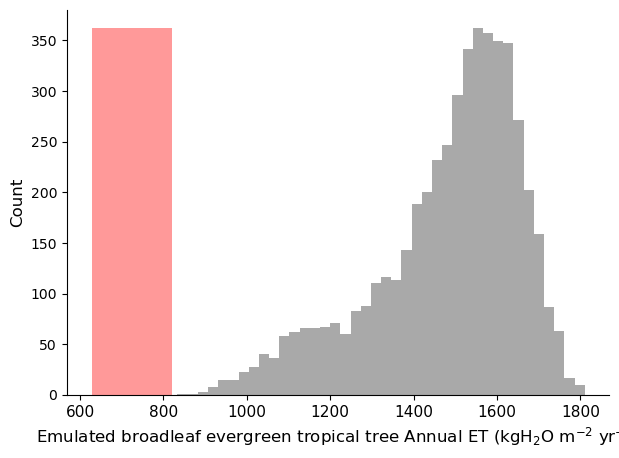

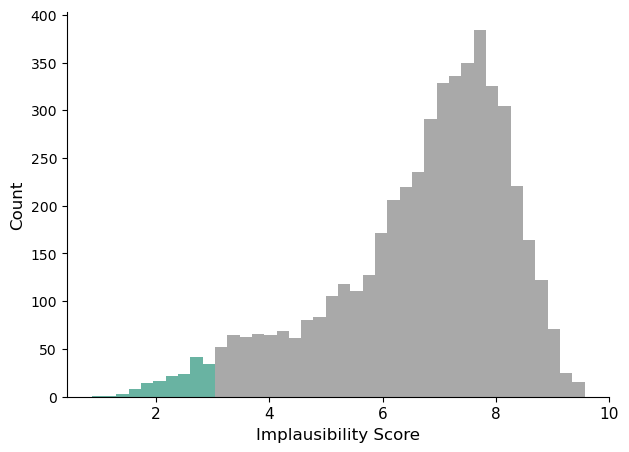

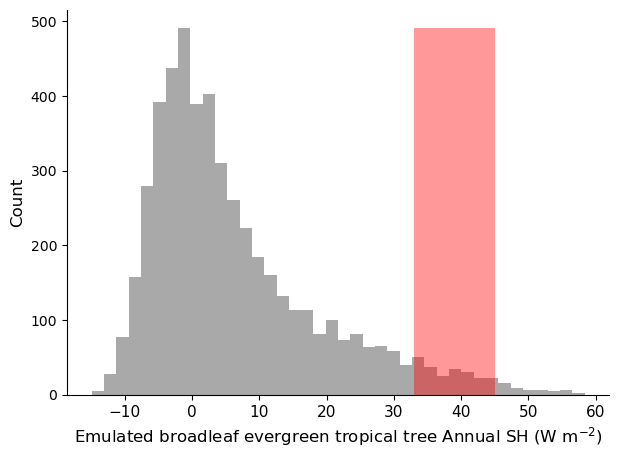

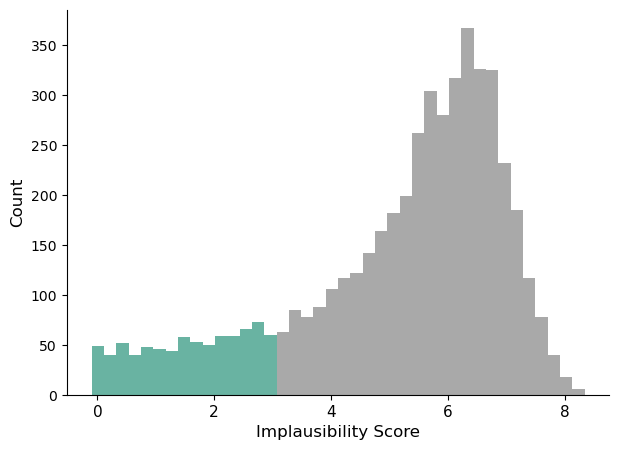

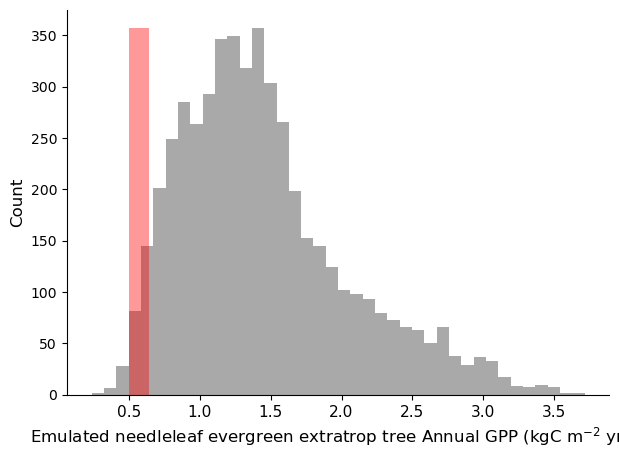

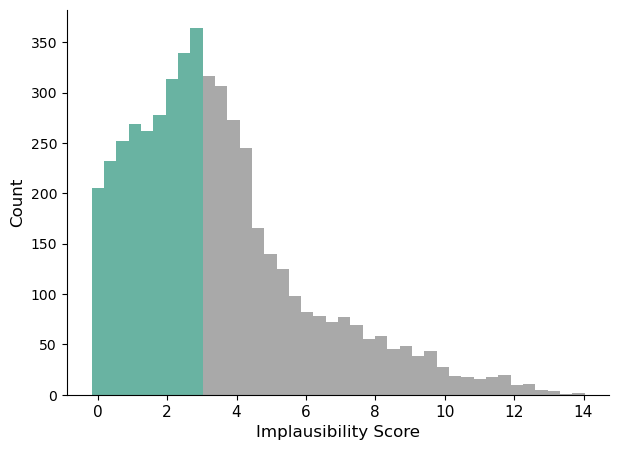

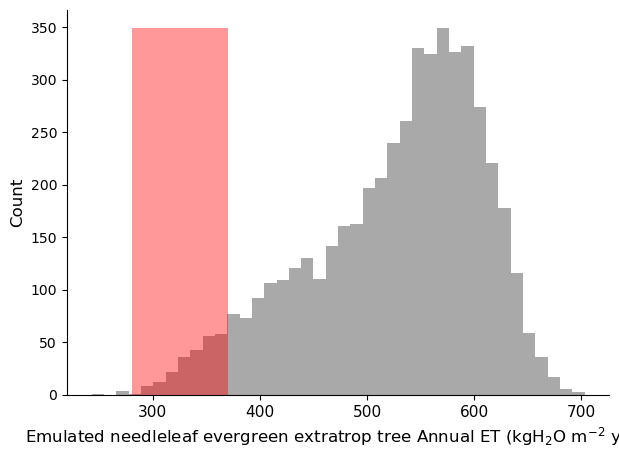

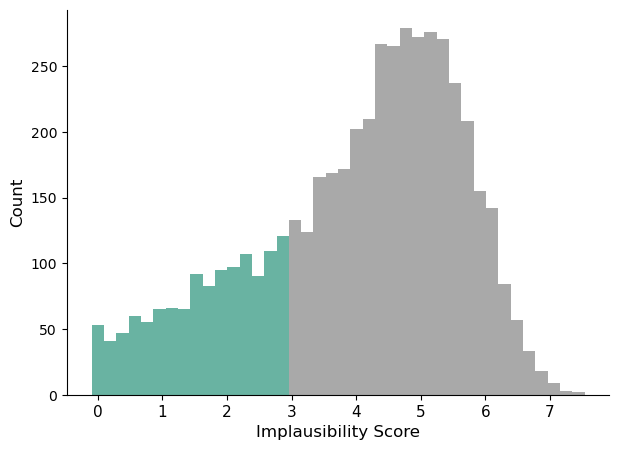

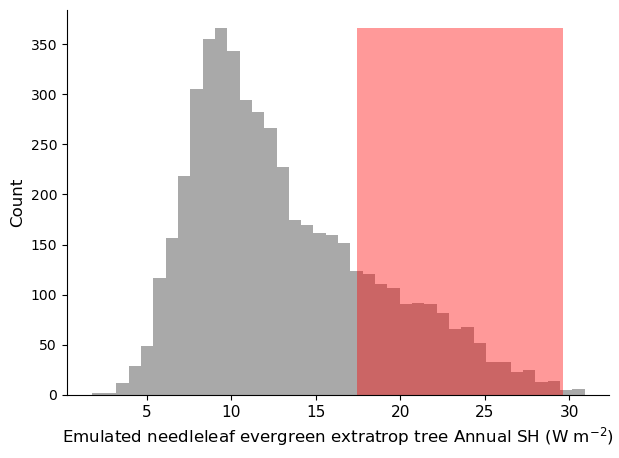

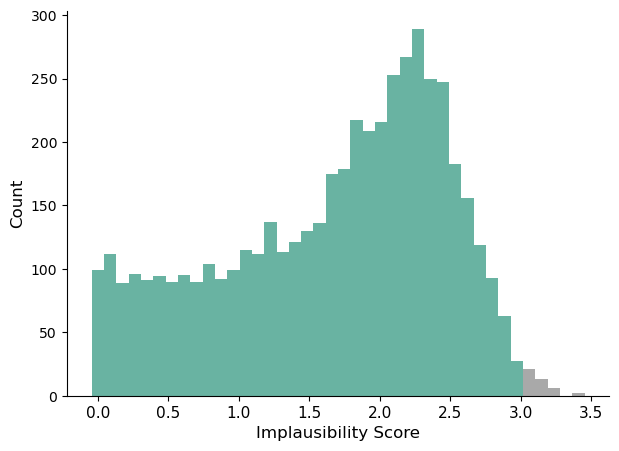

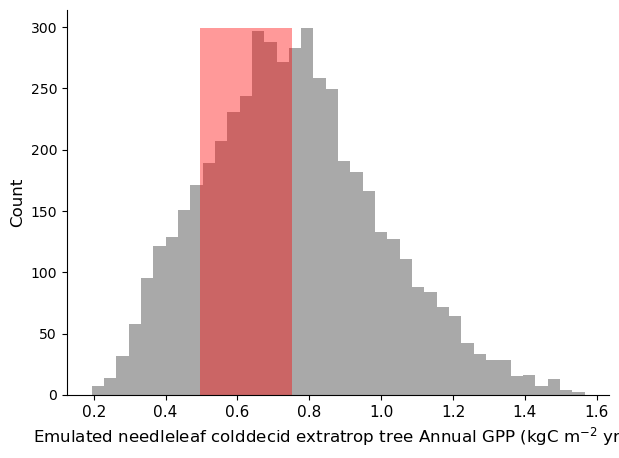

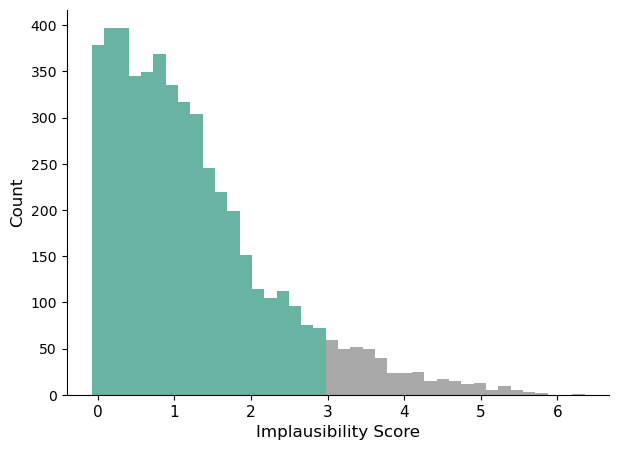

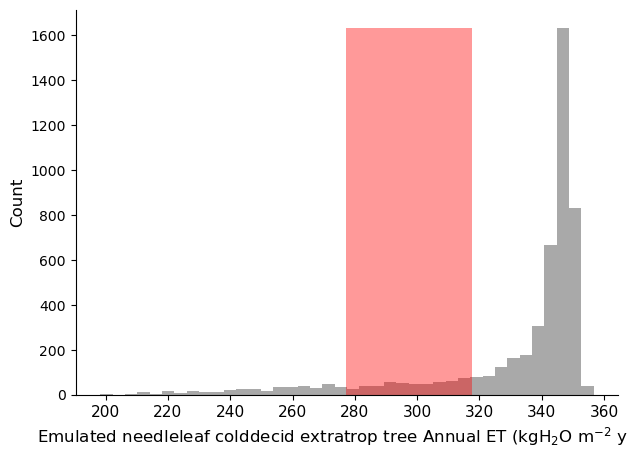

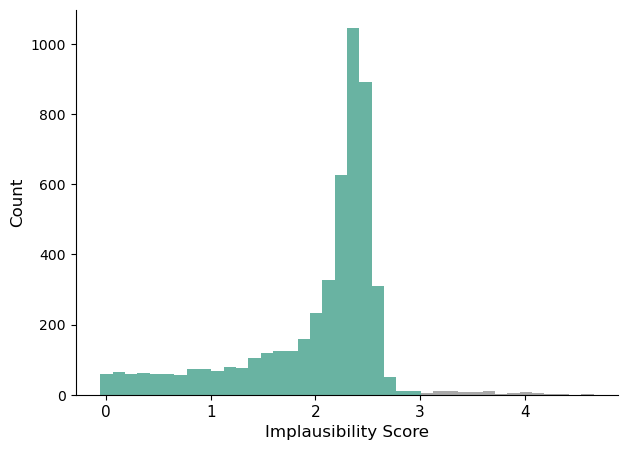

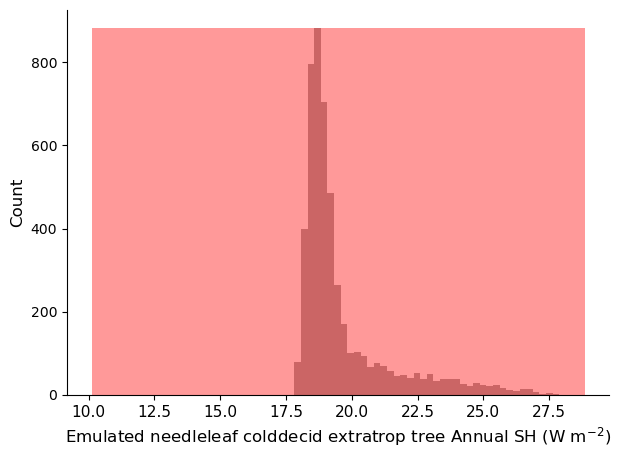

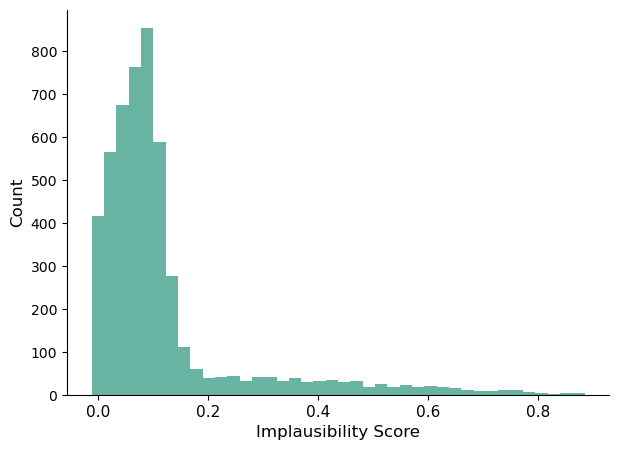

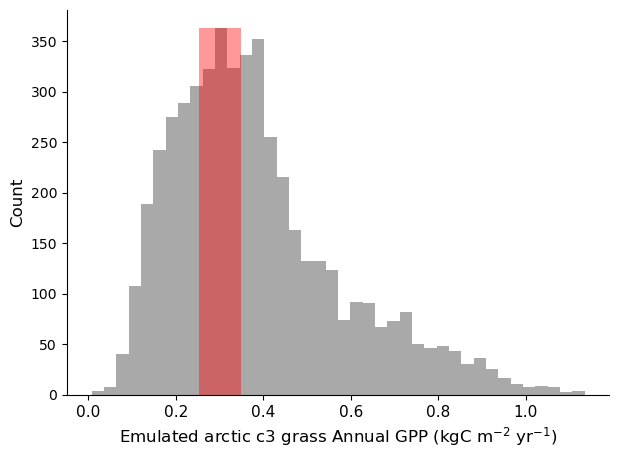

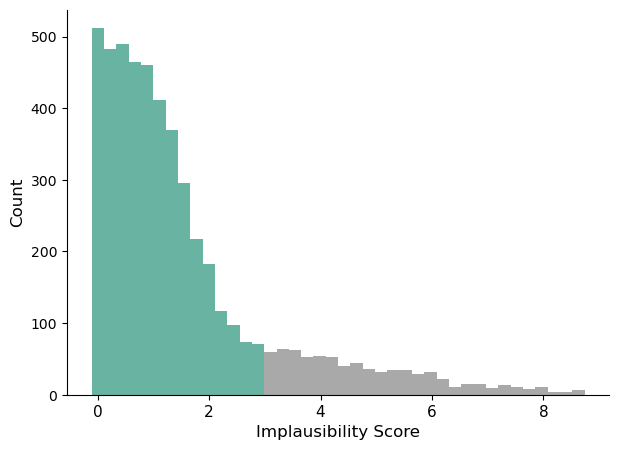

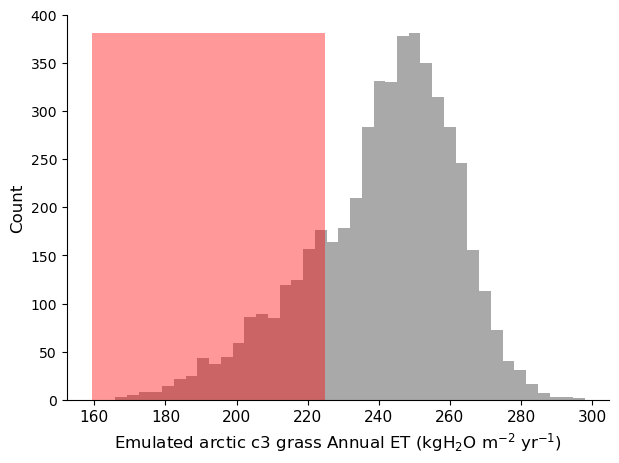

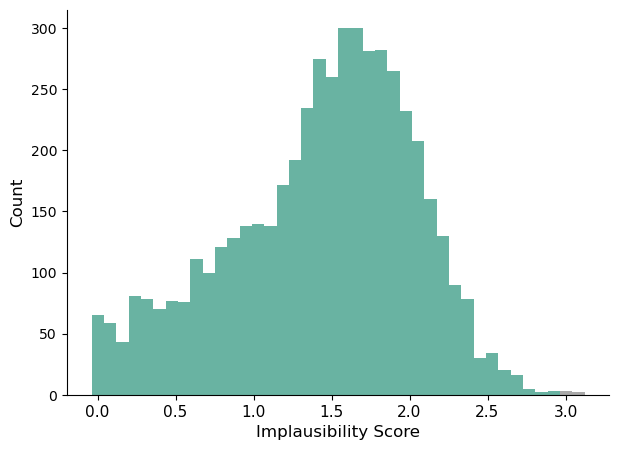

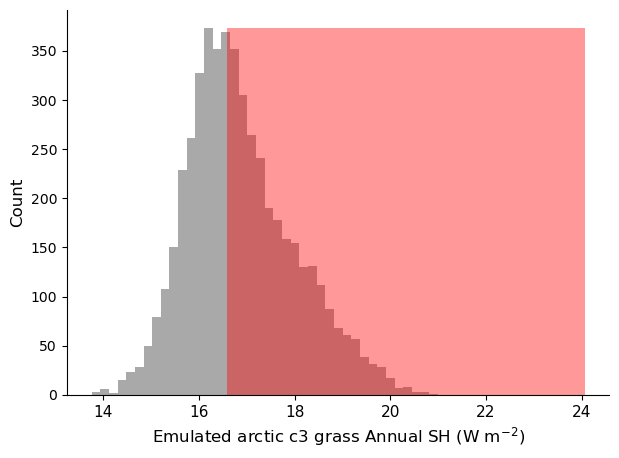

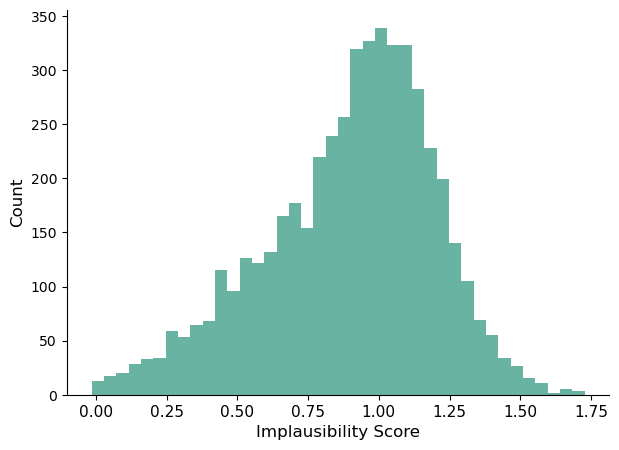

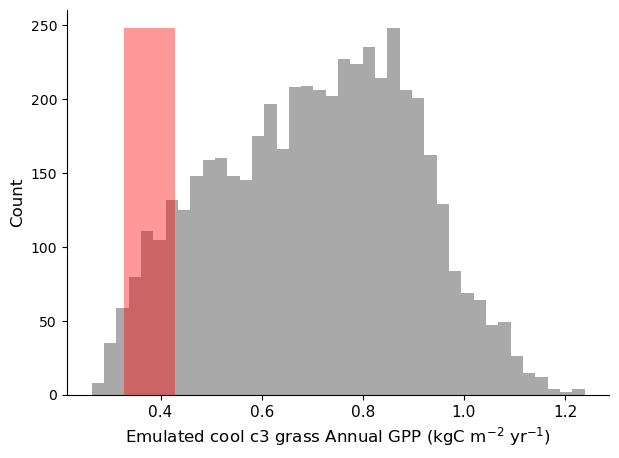

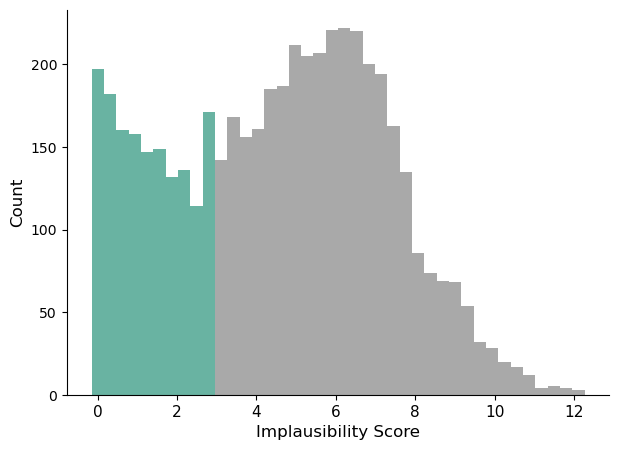

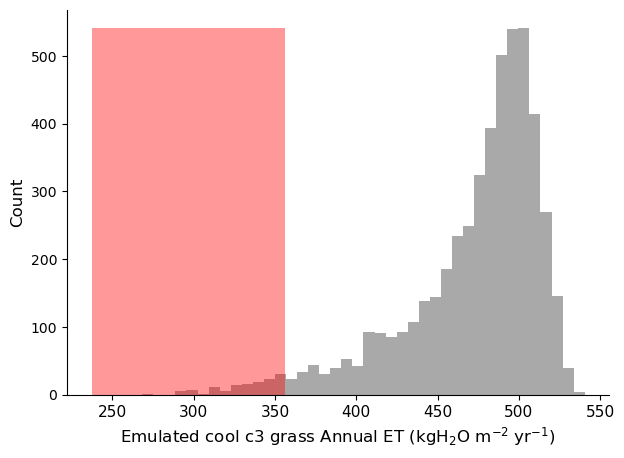

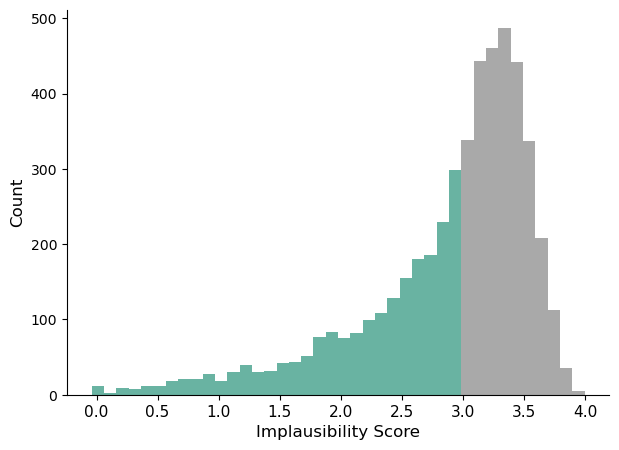

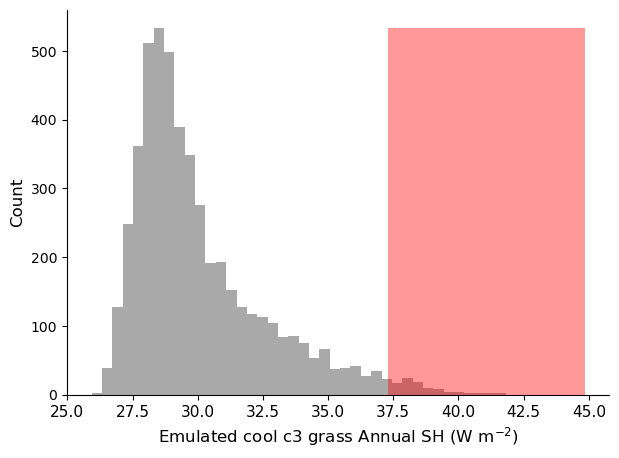

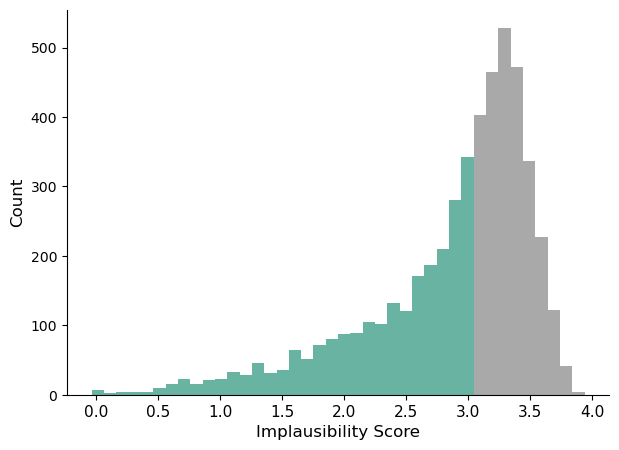

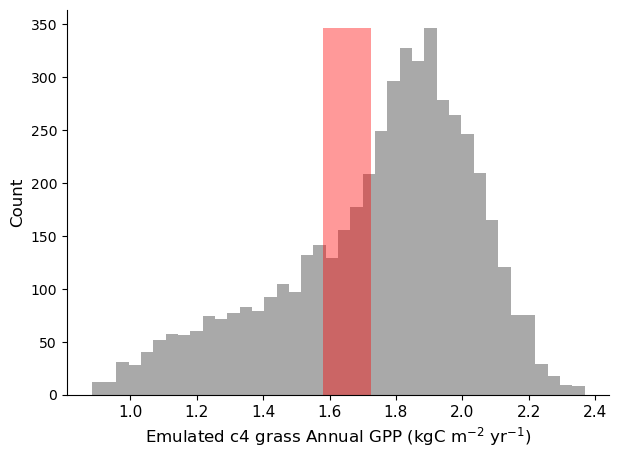

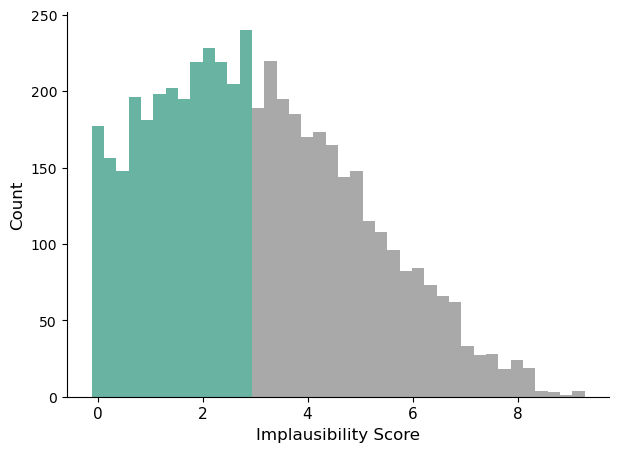

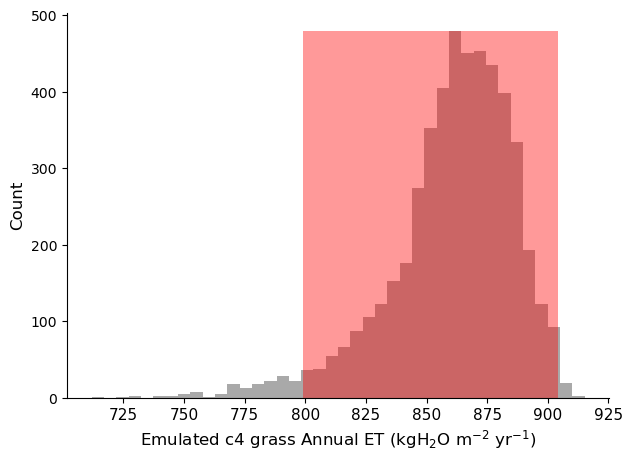

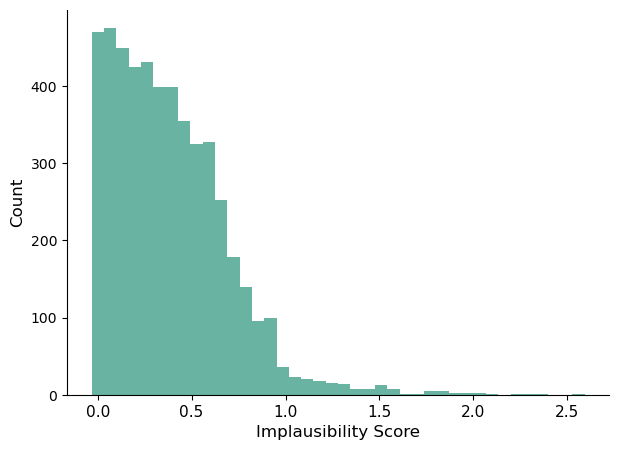

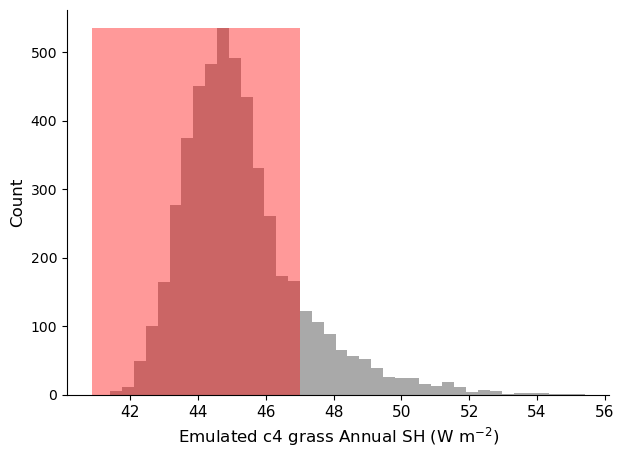

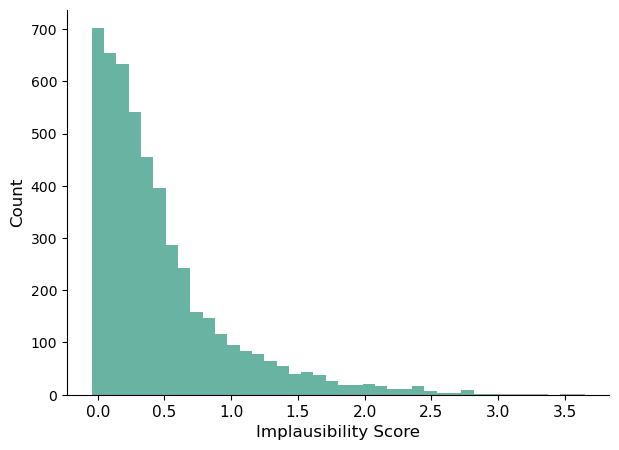

In [41]:
for pft in fates_pfts:
    num_grids = grid_pfts[grid_pfts.pft == pft]['num_gridcells'].values[0]
    if num_grids > 3:
        grids = [int(g) for g in grid_pfts[grid_pfts.pft == pft]['gridcells'].values[0].split(',')]
        ds_pft = ds.where(ds.gridcell.isin(grids), drop=True)
        obs_pft = obs[obs.gridcell.isin(grids)]
        print(f"evaluating at {num_grids} grids for {pft}")
        preds, sens, oaat, emulators = train_and_test_allvars(ds_pft, ppe_params,
                                                              n_test, vars, out_dir, pft,
                                                              average_dim='gridcell')
        preds.to_csv(os.path.join(out_dir, f'emulator_validation_{pft}.csv'))
        sens.to_csv(os.path.join(out_dir, f'fourier_sensitivity_{pft}.csv'))
        oaat.to_csv(os.path.join(out_dir, f'oaat_sensitivity_{pft}.csv'))
        
        sample_dfs = []
        for i, var in enumerate(vars):
            obs_values = obs_pft[obs_pft.variable == obs_vars[i]].groupby('model').value.mean()
            sample_df = emulator_sample(emulators[var], sample_update, obs_values,
                                        plausibility_tolerance, varnames[i],
                                        units[i], var, pft, out_dir, ens)
            sample_dfs.append(sample_df)
        all_samples = reduce(lambda x, y: pd.merge(x, y), sample_dfs)
        all_samples.to_csv(os.path.join(out_dir, f'emulator_sample_{pft}.csv'))
    
    else:
        print(f'number of gridcells too few ({num_grids}) for {pft}')

In [61]:
samples = pd.read_csv('../LH/LH_output_byPFT500/emulator_sample_needleleaf evergreen extratrop tree.csv')

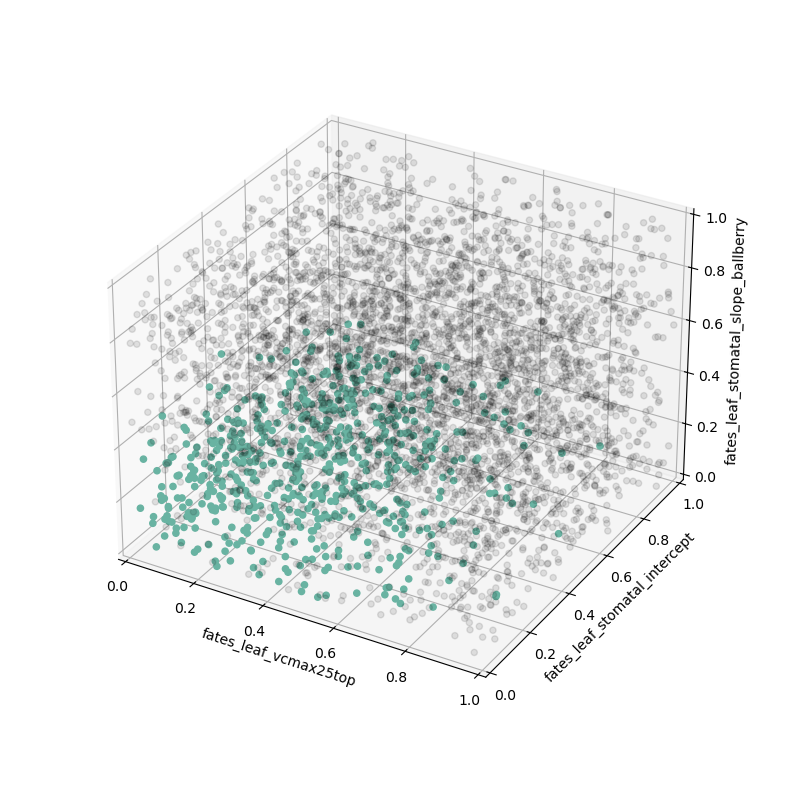

In [69]:
param_1 = 'fates_leaf_vcmax25top'
param_2 = 'fates_leaf_stomatal_intercept'
param_3 = 'fates_leaf_stomatal_slope_ballberry'

good1 = samples[samples['GPP_good']]
samples1 = samples[~(samples['GPP_good'])]

good2 = samples[samples['GPP_good'] & samples['FSH_good']]
samples2 = samples[~(samples['GPP_good'] & samples['FSH_good'])]

good3 = samples[samples['GPP_good'] & samples['FSH_good'] & samples['EFLX_LH_TOT_good']]
samples3 = samples[~(samples['GPP_good'] & samples['FSH_good']& samples['EFLX_LH_TOT_good'])]


samps = samples3
good = good3

ax = plt.figure(figsize=[10, 10]).add_subplot(projection='3d')
ax.scatter(samps[param_1], samps[param_2], samps[param_3],
           zdir='y', c = 'black', alpha = 0.1)
ax.scatter(good[param_1], good[param_2], good[param_3],
            zdir='y', c = '#69B3A2', alpha = 1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel(param_1, fontsize=10)
ax.set_ylabel(param_2, fontsize=10)
ax.set_zlabel(param_3, fontsize=10)
ax.set_box_aspect(None, zoom=0.85)
plt.savefig('../general_figs/emulated_sample_needleleaf_gpp_sh_et.png', bbox_inches='tight')

# Re-Doing Emulator Sampling with Updated Parameter Scales

In [ ]:
pfts_to_tune = ['broadleaf evergreen tropical tree',
                "needleleaf evergreen extratrop tree",
                "needleleaf colddecid extratrop tree",
                "arctic c3 grass",
                "cool c3 grass",
                "c4 grass"]
pft_indices = ["1", "2", "3", "10", "11", "12"]
pars_to_tune = ["fates_leaf_jmaxse", "fates_leaf_stomatal_intercept",
                "fates_leaf_stomatal_slope_ballberry", "fates_leaf_vcmax25top",
                "fates_leaf_vcmaxha", "fates_leaf_vcmaxhd", "fates_leaf_vcmaxse",
                "fates_maintresp_leaf_atkin2017_baserate", "fates_nonhydro_smpsc"]

In [ ]:
scaled_defaults = pd.read_csv('../default_scaled_values.csv')

In [ ]:
for p in range(len(pfts_to_tune)):
    
    pft_index = pft_indices[p]
    pft = pfts_to_tune[p]
    
    num_grids = grid_pfts[grid_pfts.pft == pft]['num_gridcells'].values[0]
    grids = [int(g) for g in grid_pfts[grid_pfts.pft == pft]['gridcells'].values[0].split(',')]
    ds_pft = ds.where(ds.gridcell.isin(grids), drop=True)
    obs_pft = obs[obs.gridcell.isin(grids)]
    print(f"evaluating at {num_grids} grids for {pft}")
    
    default_sub = scaled_defaults[scaled_defaults.pft.isin([pft_index, "none"])]
    pars = ppe_params.columns
    pars_to_keep = []
    scaled_val = []
    for par in pars:
        if par not in pars_to_tune:
            pars_to_keep.append(par)
            default_val = default_sub[default_sub.parameter == par]['default_prob'].values[0]
            scaled_val.append(default_val)
    n_samp = 3000
    sample = get_random_params(num_params, n_samp)
    pft_sample_update = sample
    for i in range(len(pft_sample_update)):
        for j in range(len(pars_to_keep)):
            ind = np.where(pars == pars_to_keep[j])
            pft_sample_update[i][ind] = scaled_val[j]
    
    preds, sens, oaat, emulators = train_and_test_allvars(ds_pft, ppe_params,
                                                          n_test, vars, '../LH/LH_output_byPFT_update', pft,
                                                          average_dim='gridcell')

    sample_dfs = []
    for i, var in enumerate(vars):
        obs_values = obs_pft[obs_pft.variable == obs_vars[i]].groupby('model').value.mean()
        sample_df = emulator_sample(emulators[var], pft_sample_update, obs_values,
                                    plausibility_tolerance, varnames[i],
                                    units[i], var, pft, '../LH/LH_output_byPFT_update',
                                    ens)
        sample_dfs.append(sample_df)
    all_samples = reduce(lambda x, y: pd.merge(x, y), sample_dfs)
    all_samples.to_csv(f'../LH/LH_output_byPFT_update/emulator_sample_{pft}.csv')